# Image Processing (Part 1) Spatial Domain

<div>
<iframe src="https://slides.com/naresh-ub/cvip-lec-4/embed" width="100%" height="500" title="Test Title" scrolling="no" frameborder="0" webkitallowfullscreen mozallowfullscreen allowfullscreen></iframe>
</div>

As we established multiple times in this course that images are nothing but `numpy arrays` where each value in the grid represents a pixel. In the case of a grayscale image, the pixel represents intensity from `0 to 255` and in the case of a colored RGB image, each pixel is a vector `[R, G, B]` values ranging from 0 to 255. Depending on different combinations of R, G, and B, we can visualize different colors at each pixel.

*In this lecture, we will look at various image processing techniques that will result in extraction of various features from images.*

To get started, lets look at some simple image transformations that we can perform with the information that an image is simply a numpy array.

```{admonition} Use the Live Code feature in this webpage
:class: tip

Already installed packages: `skimage, cv2, matplotlib` (other required packages).

Hit the rocket icon on the top right, and wait for `python interaction ready`.

```

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_side_by_side(original, transformed, cmap='gray'):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original, cmap=cmap)
    axes[0].set_title("Original Image")
    axes[0].axis('off')
    
    axes[1].imshow(transformed, cmap=cmap)
    axes[1].set_title("Transformed Image")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

<class 'numpy.ndarray'> (512, 512)


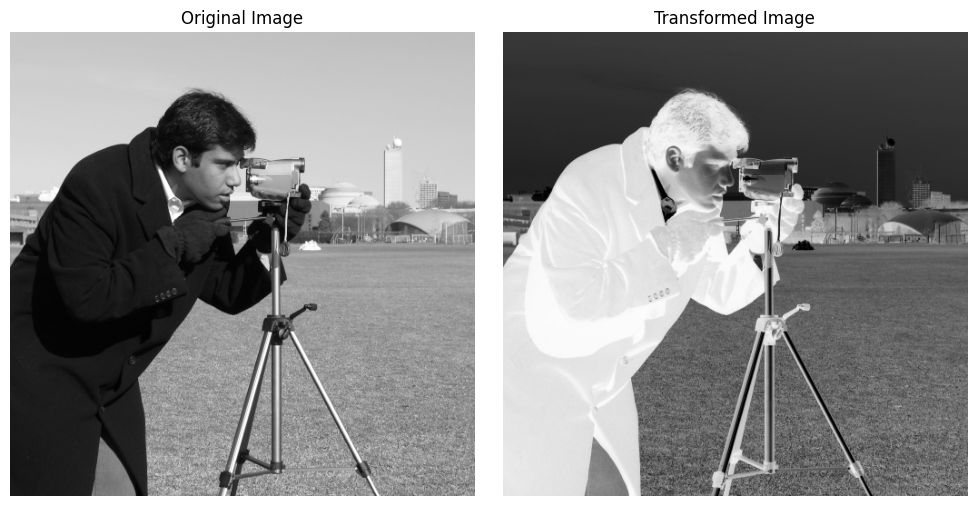

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import affine_transform
from skimage import data
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

# Load image
image = data.camera()
transformed = np.zeros_like(image) # Creates an empty array with the same shape as the image

print(type(image), image.shape)

for i in range(image.shape[0]):
  for j in range(image.shape[1]):
    transformed[i,j] = 255 - image[i,j] # This code simply inverts the image
    
plot_side_by_side(image, transformed)

The above code is a nice way to interact with numpy arrays. _Try performing some other transformations using Numpy Arrays._

`Play around with different images that are pre-built into the matplotlib library. Image reading from URLs is not currently supported yet.`

## Simple Affine Transformations

In the next part of the code, we borrow concepts from Linear Algebra to perform various transformations such as `Scaling, Shear, Translation` using Matrix Multiplication. To explain this concept let's take a simple scenario where an image is made up of a 2*2 grid.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output

# Define square
square = np.array([
    [-1, -1],
    [1, -1],
    [1, 1],
    [-1, 1],
    [-1, -1]  # Close the square
])

# Display matrix and translation vector in HTML
def matrix_html_display(a00, a01, a10, a11, tx, ty):
    return HTML(
        f"<div style='font-size: 20px; font-family: monospace; color: gray;'>"
        f"<strong>Transformation:</strong><br>"
        f"<strong>x′ = A·x + v</strong><br><br>"
        f"A = [ [{a00:.2f}, {a01:.2f}]<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[{a10:.2f}, {a11:.2f}] ]<br><br>"
        f"v = [ {tx:.2f} ]<br>"
        f"&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[ {ty:.2f} ]"
        f"</div>"
    )

# Main interactive function
def show_square_affine_transform(interactive=True, a00=1.0, a01=0.0, a10=0.0, a11=1.0, tx=0.0, ty=0.0):
    if not interactive:
        display(matrix_html_display(a00, a01, a10, a11, tx, ty))
        apply_affine_to_square_and_plot(a00, a01, a10, a11, tx, ty)
        return

    # Matrix sliders
    a00_slider = widgets.FloatSlider(value=a00, min=-2.0, max=2.0, step=0.01, description='A[0,0]')
    a01_slider = widgets.FloatSlider(value=a01, min=-2.0, max=2.0, step=0.01, description='A[0,1]')
    a10_slider = widgets.FloatSlider(value=a10, min=-2.0, max=2.0, step=0.01, description='A[1,0]')
    a11_slider = widgets.FloatSlider(value=a11, min=-2.0, max=2.0, step=0.01, description='A[1,1]')

    # Translation sliders
    tx_slider = widgets.FloatSlider(value=tx, min=-5.0, max=5.0, step=0.1, description='tx')
    ty_slider = widgets.FloatSlider(value=ty, min=-5.0, max=5.0, step=0.1, description='ty')

    slider_box = widgets.VBox([
        a00_slider, a01_slider, a10_slider, a11_slider,
        widgets.Label("Translation Vector"),
        tx_slider, ty_slider
    ])
    matrix_box = widgets.HTML()

    def update_matrix_display(a00, a01, a10, a11, tx, ty):
        matrix_box.value = (
            f"<div style='font-size: 20px; font-family: monospace; color: gray;'>"
            f"<strong>x′ = A·x + v</strong><br><br>"
            f"A = [ [{a00:.2f}, {a01:.2f}]<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[{a10:.2f}, {a11:.2f}] ]<br><br>"
            f"v = [ {tx:.2f} ]<br>"
            f"&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[ {ty:.2f} ]"
            f"</div>"
        )

    def full_update(a00, a01, a10, a11, tx, ty):
        update_matrix_display(a00, a01, a10, a11, tx, ty)
        apply_affine_to_square_and_plot(a00, a01, a10, a11, tx, ty)

    interactive_plot = widgets.interactive_output(
        full_update,
        {'a00': a00_slider, 'a01': a01_slider, 'a10': a10_slider, 'a11': a11_slider,
         'tx': tx_slider, 'ty': ty_slider}
    )

    ui_row = widgets.HBox([
        slider_box,
        widgets.Box([matrix_box], layout=widgets.Layout(padding='0 0 0 50px'))
    ])

    display(ui_row, interactive_plot)

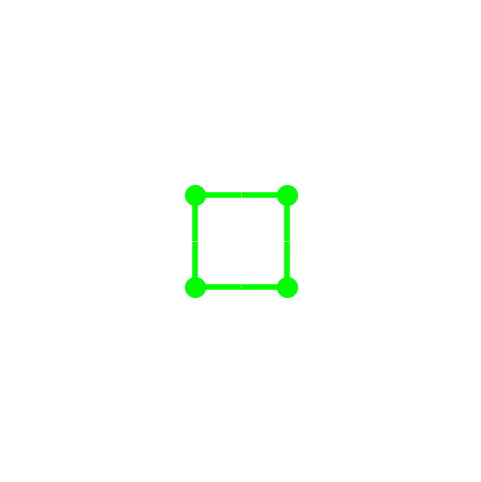

In [ ]:
# Plot function
def apply_affine_to_square_and_plot(a00, a01, a10, a11, tx, ty):
    A = np.array([[a00, a01],
                  [a10, a11]])
    t = np.array([tx, ty])

    transformed_square = (square @ A.T) + t

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_facecolor("black")
    ax.plot(square[:, 0], square[:, 1], color='lime', linewidth=2, alpha=0.3, label='Original')
    ax.plot(transformed_square[:, 0], transformed_square[:, 1], color='lime', linewidth=4, label='Transformed')
    ax.scatter(transformed_square[:-1, 0], transformed_square[:-1, 1], s=200, color='lime')
    ax.axhline(0, color='white', linewidth=0.5, linestyle='--')
    ax.axvline(0, color='white', linewidth=0.5, linestyle='--')
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_aspect('equal')
    ax.axis('off')
    plt.show()
    
show_square_affine_transform(interactive=True) # interactive = True to enable sliders

In the above code we observe that a simple 2D matrix can perform scaling and shear transformation, while a vector can perform translation transformation.

Another interesting detail is that `shear and scaling transformations together can result in rotation transformation`. Play around with the sliders to simulate this!

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, HTML

# Define original square
square = np.array([
    [-1, -1],
    [1, -1],
    [1, 1],
    [-1, 1],
    [-1, -1]  # Closing the loop
])

# Display rotation matrix as HTML
def rotation_matrix_html(theta_deg):
    theta_rad = np.radians(theta_deg)
    cos_val = np.cos(theta_rad)
    sin_val = np.sin(theta_rad)
    return HTML(
        f"<div style='font-size: 20px; font-family: monospace; color: gray;'>"
        f"<strong>Rotation Matrix (θ = {theta_deg:.1f}°):</strong><br><br>"
        f"R(θ) = [ [cos(θ), -sin(θ)]<br>"
        f"&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[sin(θ), cos(θ)] ]<br><br>"
        f"&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;= [ [{cos_val:.2f}, {-sin_val:.2f}]<br>"
        f"&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[{sin_val:.2f}, {cos_val:.2f}] ]"
        f"</div>"
    )

# Plot rotated square
def plot_rotated_square(theta_deg):
    R = rotation_matrix(theta_deg)
    rotated = square @ R.T

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_facecolor('black')
    ax.plot(square[:, 0], square[:, 1], color='lime', linewidth=2, alpha=0.3, label='Original')
    ax.plot(rotated[:, 0], rotated[:, 1], color='lime', linewidth=4, label='Rotated')
    ax.scatter(rotated[:-1, 0], rotated[:-1, 1], s=200, color='lime')
    ax.axhline(0, color='white', linewidth=0.5, linestyle='--')
    ax.axvline(0, color='white', linewidth=0.5, linestyle='--')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_aspect('equal')
    ax.axis('off')
    plt.show()

# Master function with interactive toggle
def show_rotation_transform(interactive=True, theta_deg=0):
    if not interactive:
        display(rotation_matrix_html(theta_deg))
        plot_rotated_square(theta_deg)
        return

    theta_slider = widgets.FloatSlider(value=theta_deg, min=-180, max=180, step=1, description='Angle θ')
    matrix_box = widgets.HTML()

    def update(theta):
        matrix_box.value = rotation_matrix_html(theta).data
        plot_rotated_square(theta)

    interactive_plot = widgets.interactive_output(update, {'theta': theta_slider})

    ui = widgets.HBox([
        theta_slider,
        widgets.Box([matrix_box], layout=widgets.Layout(padding='0 0 0 50px'))
    ])

    display(ui, interactive_plot)

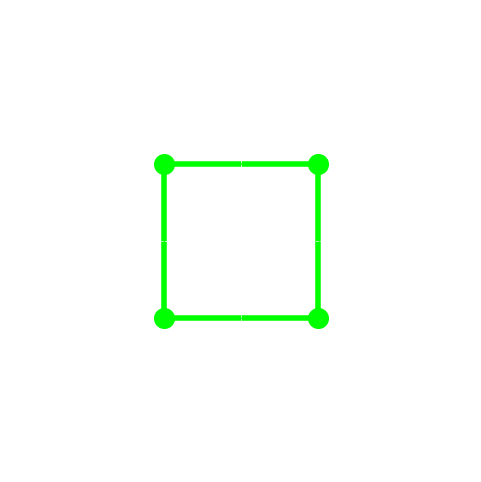

In [ ]:
# Function to create rotation matrix
def rotation_matrix(theta_deg):
    theta_rad = np.radians(theta_deg)
    return np.array([
        [np.cos(theta_rad), -np.sin(theta_rad)],
        [np.sin(theta_rad),  np.cos(theta_rad)]
    ])

show_rotation_transform(interactive=True)  # interactive = True to enable sliders

## Affine transformations on Grayscale images

Now, let's apply these transformations to images.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import affine_transform
from skimage import data
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

# Load image
image = data.camera()

# Matrix display (HTML format)
def matrix_html_display(a00, a01, a10, a11):
    return HTML(
        f"<div style='font-size: 22px; font-family: monospace; color: gray;'>"
        f"A = [ [{a00:.2f}, {a01:.2f}]<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[{a10:.2f}, {a11:.2f}] ]"
        f"</div>"
    )


# Main driver
def show_affine_transform(interactive=True, a00=1.0, a01=0.0, a10=0.0, a11=1.0):
    if not interactive:
        display(matrix_html_display(a00, a01, a10, a11))
        apply_affine_and_plot(a00, a01, a10, a11)
        return

    # Sliders
    a00_slider = widgets.FloatSlider(value=a00, min=-2.0, max=2.0, step=0.01, description='A[0,0]')
    a01_slider = widgets.FloatSlider(value=a01, min=-2.0, max=2.0, step=0.01, description='A[0,1]')
    a10_slider = widgets.FloatSlider(value=a10, min=-2.0, max=2.0, step=0.01, description='A[1,0]')
    a11_slider = widgets.FloatSlider(value=a11, min=-2.0, max=2.0, step=0.01, description='A[1,1]')

    slider_box = widgets.VBox([a00_slider, a01_slider, a10_slider, a11_slider])
    matrix_box = widgets.HTML()

    # Update HTML matrix
    def update_matrix_display(a00, a01, a10, a11):
        matrix_box.value = (
            f"<div style='font-size: 22px; font-family: monospace; color: gray;'>"
            f"A = [ [{a00:.2f}, {a01:.2f}]<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[{a10:.2f}, {a11:.2f}] ]"
            f"</div>"
        )

    # Combined update
    def full_update(a00, a01, a10, a11):
        update_matrix_display(a00, a01, a10, a11)
        apply_affine_and_plot(a00, a01, a10, a11)

    # Bind interactive output
    interactive_plot = widgets.interactive_output(
        full_update,
        {'a00': a00_slider, 'a01': a01_slider, 'a10': a10_slider, 'a11': a11_slider}
    )

    # Final UI
    ui_row = widgets.HBox([
        slider_box,
        widgets.Box([matrix_box], layout=widgets.Layout(padding='0 0 0 50px'))
    ])

    display(ui_row, interactive_plot)

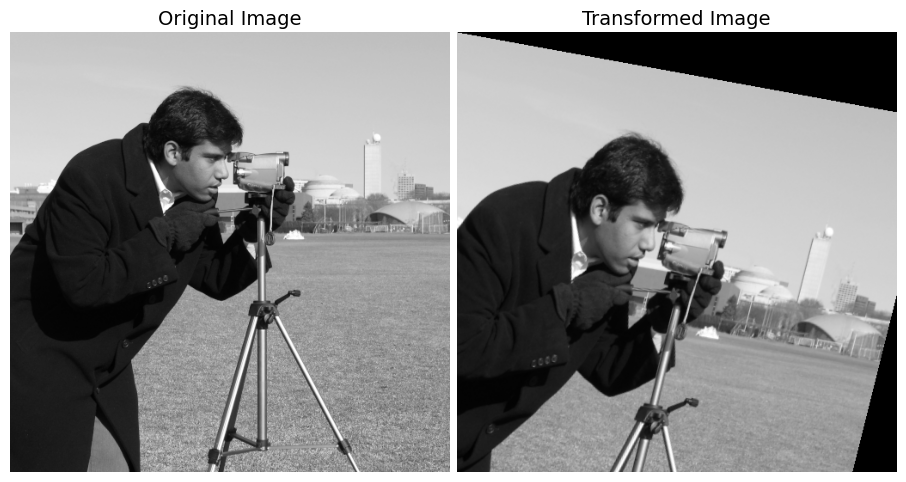

In [ ]:
def apply_affine_and_plot(a00, a01, a10, a11):
    A = np.array([[a00, a01],
                  [a10, a11]])
    try:
        invA = np.linalg.inv(A)
    except np.linalg.LinAlgError:
        invA = np.eye(2)

    transformed = affine_transform(image, invA, offset=0, order=1, mode='constant')

    fig, axs = plt.subplots(1, 2, figsize=(9, 5))
    axs[0].imshow(image, cmap='gray')
    axs[0].axis('off')
    axs[0].set_title("Original Image", fontsize=14)

    axs[1].imshow(transformed, cmap='gray')
    axs[1].axis('off')
    axs[1].set_title("Transformed Image", fontsize=14)

    plt.tight_layout(pad=0.5)
    plt.show()
    
show_affine_transform(interactive=True)  # default interactive

We see that some information is lost while performing shear and scale transformation. We take a look at `interpolation` to fill in the values for these pixels.

## BiLinear Interpolation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, HTML

# 5x5 grayscale image
original_image = np.array([
    [  0,  50, 100, 150, 200],
    [ 10,  60, 110, 160, 210],
    [ 20,  70, 120, 170, 220],
    [ 30,  80, 130, 180, 230],
    [ 40,  90, 140, 190, 240]
], dtype=np.uint8)

# Bilinear interpolation function
def bilinear_interpolate(img, x, y):
    i, j = int(np.floor(x)), int(np.floor(y))
    dx, dy = x - i, y - j

    if i < 0 or i >= img.shape[1] - 1 or j < 0 or j >= img.shape[0] - 1:
        return 0, (0, 0, 0, 0), (0, 0)

    f00 = img[j, i]
    f10 = img[j, i+1]
    f01 = img[j+1, i]
    f11 = img[j+1, i+1]

    interpolated = (
        f00 * (1 - dx) * (1 - dy) +
        f10 * dx * (1 - dy) +
        f01 * (1 - dx) * dy +
        f11 * dx * dy
    )
    return interpolated, (f00, f10, f01, f11), (dx, dy)

# Plotting and explanation function
def plot_interpolation(x, y):
    interp_val, (f00, f10, f01, f11), (dx, dy) = bilinear_interpolate(original_image, x, y)

    fig, ax = plt.subplots(figsize=(5.5, 5.5))
    ax.imshow(original_image, cmap='gray', vmin=0, vmax=255)
    ax.set_xticks(np.arange(0, 5))
    ax.set_yticks(np.arange(0, 5))
    ax.grid(True, color='lightgray')

    for i in range(original_image.shape[1]):
        for j in range(original_image.shape[0]):
            ax.text(i, j, f"{original_image[j, i]}", ha='center', va='center',
                    fontsize=10, color='red', fontweight='bold')

    ax.plot(x, y, 'ro', label=f"Interpolated: {interp_val:.2f}")
    ax.set_title(f"Bilinear Interpolation at ({x:.2f}, {y:.2f}) = {interp_val:.2f}")
    ax.legend(loc='upper left')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.show()

    print("Static Equation:")
    print("I(x, y) = f00*(1-dx)*(1-dy) + f10*dx*(1-dy) + f01*(1-dx)*dy + f11*dx*dy\n")

    print("Dynamic Equation:")
    print(f"I({x:.2f}, {y:.2f}) = "
          f"{f00}*(1-{dx:.2f})*(1-{dy:.2f}) + "
          f"{f10}*{dx:.2f}*(1-{dy:.2f}) + "
          f"{f01}*(1-{dx:.2f})*{dy:.2f} + "
          f"{f11}*{dx:.2f}*{dy:.2f} = {interp_val:.2f}")

# Master function
def show_bilinear_interpolation(interactive=False, x=2.5, y=2.5):
    display(HTML("<h5 style='font-family: sans-serif;'>Interactive Bilinear Interpolation Demo</h5>"))
    
    if not interactive:
        plot_interpolation(x, y)
        return

    x_slider = widgets.FloatSlider(value=x, min=0.01, max=3.99, step=0.01, description='x')
    y_slider = widgets.FloatSlider(value=y, min=0.01, max=3.99, step=0.01, description='y')

    ui = widgets.VBox([x_slider, y_slider])
    out = widgets.interactive_output(plot_interpolation, {'x': x_slider, 'y': y_slider})

    display(ui, out)

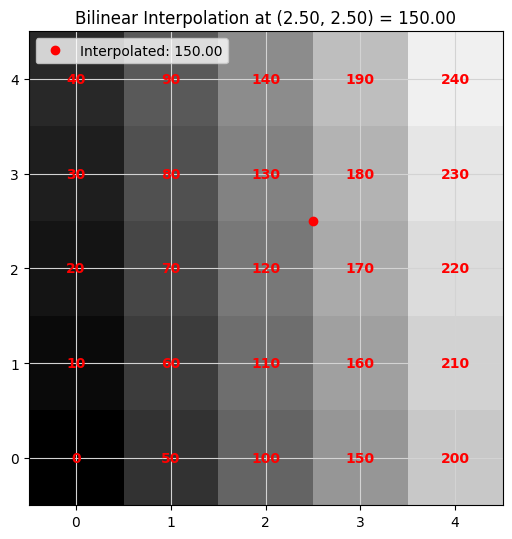

Static Equation:
I(x, y) = f00*(1-dx)*(1-dy) + f10*dx*(1-dy) + f01*(1-dx)*dy + f11*dx*dy

Dynamic Equation:
I(2.50, 2.50) = 120*(1-0.50)*(1-0.50) + 170*0.50*(1-0.50) + 130*(1-0.50)*0.50 + 180*0.50*0.50 = 150.00


In [2]:
show_bilinear_interpolation(interactive=True)  # Set to True to enable sliders

### Can Interpolation restore missing pixels from an image and perform inpainting task?

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color, restoration
from scipy.interpolate import griddata
import cv2

# Load and prepare grayscale image
def load_image():
    image = color.rgb2gray(data.astronaut())  # Convert astronaut image to grayscale
    return cv2.resize(image, (256, 256))

# Create mask with missing regions
def create_mask(image_shape):
    mask = np.ones(image_shape)
    mask[60:120, 100:160] = 0  # large rectangular missing region
    mask[180:220, 50:90] = 0
    return mask

# Bilinear interpolation using known pixel values
def bilinear_interpolate_image(image, mask):
    coords = np.array(np.nonzero(mask)).T
    values = image[mask == 1]
    grid_x, grid_y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
    return griddata(coords, values, (grid_y, grid_x), method='linear', fill_value=0)

# Inpainting using skimage's biharmonic method
def inpaint_image(image, mask):
    return restoration.inpaint_biharmonic(image, mask == 0, channel_axis=None)

# Visualization
def plot_inpainting_results(original, damaged, interp_result, inpaint_result):
    fig, axs = plt.subplots(1, 4, figsize=(18, 5))
    axs[0].imshow(original, cmap='gray')
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(damaged, cmap='gray')
    axs[1].set_title("Damaged Image")
    axs[1].axis('off')

    axs[2].imshow(interp_result, cmap='gray')
    axs[2].set_title("Bilinear Interpolation (Fails)")
    axs[2].axis('off')

    axs[3].imshow(inpaint_result, cmap='gray')
    axs[3].set_title("Inpainting Result (Partially Works)")
    axs[3].axis('off')

    plt.tight_layout()
    plt.show()

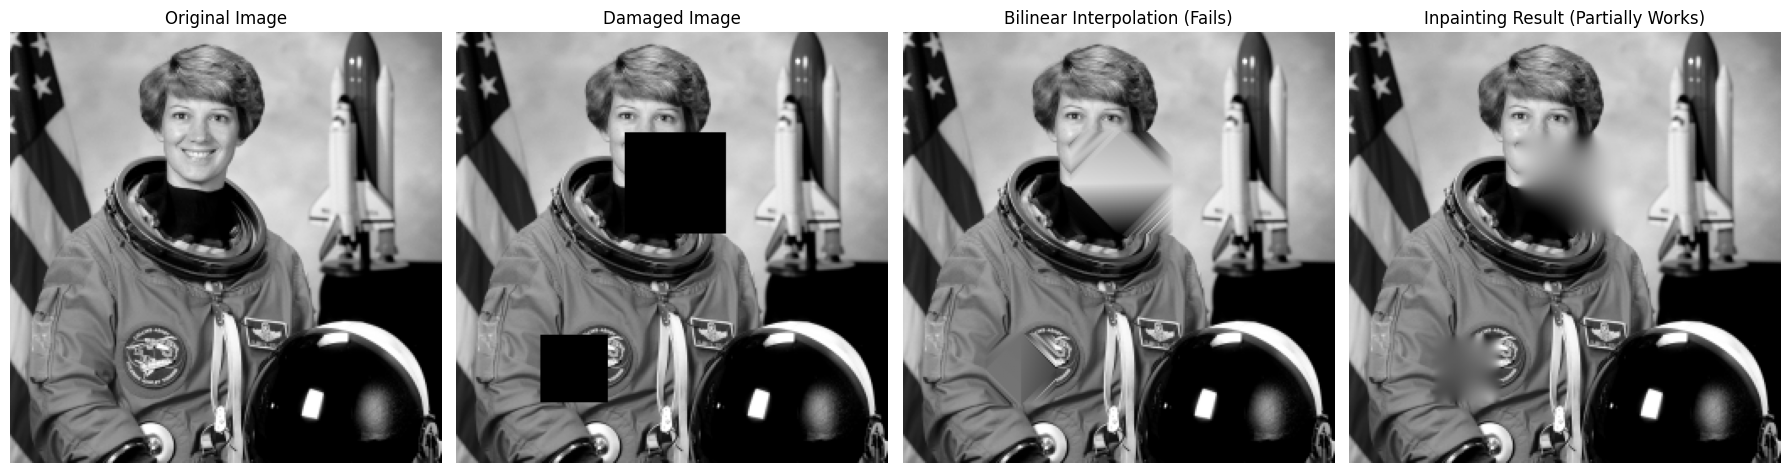

In [7]:
# Load image and create mask
image = load_image()
mask = create_mask(image.shape)
damaged = image * mask

# Apply interpolation and inpainting
interp_result = bilinear_interpolate_image(image, mask)
inpaint_result = inpaint_image(damaged, mask)

# Plot results
plot_inpainting_results(image, damaged, interp_result, inpaint_result)

## Convolution Operation in Signal Processing

We now take a look at the convolution operation from signal processing

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, HTML

# Input signal
x = np.linspace(0, 1, 50)
input_signal = np.zeros_like(x)
input_signal[10:20] = 1
input_signal[25:27] = 2
input_signal[35:40] = 0.5

# Kernel selection
def get_kernel(name):
    if name == "Box":
        return np.array([1, 1, 1]) / 3
    elif name == "Triangle":
        return np.array([1, 2, 1]) / 4
    elif name == "Edge":
        return np.array([-1, 0, 1]) / 2
    else:
        return np.array([0, 1, 0])

# Convolution visualization logic
def visualize_convolution(kernel_type, step):
    kernel = get_kernel(kernel_type)
    flipped_kernel = kernel[::-1]
    k_size = len(kernel)

    output = np.convolve(input_signal, flipped_kernel, mode='valid')
    output_x = x[:len(output)]

    fig, axs = plt.subplots(3, 1, figsize=(10, 5), sharex=False)

    # Get convolution window
    start = step
    end = start + k_size
    if end > len(input_signal): return
    window_vals = input_signal[start:end]
    window_x = x[start:end]

    # Subplot 1: Input Window
    axs[0].plot(x, input_signal, color='lightgray')
    axs[0].plot(window_x, window_vals, 'o-', color='blue', label='Window')
    axs[0].set_ylim(-0.2, 2.2)
    axs[0].set_ylabel("Input")
    axs[0].grid(True)
    axs[0].legend()

    # Subplot 2: Kernel
    axs[1].plot(window_x, flipped_kernel, 'o-', color='orange', label='Flipped Kernel')
    axs[1].set_ylim(-1.1, 1.1)
    axs[1].set_ylabel("Kernel")
    axs[1].grid(True)
    axs[1].legend()

    # Subplot 3: Output
    axs[2].plot(output_x, output, '--', color='gray', label='Total Output')
    axs[2].plot(output_x[:step+1], output[:step+1], 'o-', color='green', label='Computed So Far')
    axs[2].set_ylim(-1, 1.6)
    axs[2].set_ylabel("Output")
    axs[2].grid(True)
    axs[2].legend()

    plt.tight_layout()
    plt.show()

    # Equation Display
    header = f"<br><b>Convolution Details at Step {step}</b><br>"
    window_txt = "Window:       [" + ", ".join(f"{v:.1f}" for v in window_vals) + "]<br>"
    kernel_txt = "Kernel:       [" + ", ".join(f"{k:.2f}" for k in flipped_kernel) + "]<br>"
    mults = [f"{v:.1f}×{k:.2f}" for v, k in zip(window_vals, flipped_kernel)]
    equation_txt = "Multiplying:  " + " + ".join(mults) + "<br>"
    result = np.dot(window_vals, flipped_kernel)
    result_txt = f"Dot Product:  <b>{result:.3f}</b>"

    display(HTML(f"""
    <div style="font-family: monospace; font-size: 15px; margin-top: -10px;">
        {header}
        {window_txt}
        {kernel_txt}
        {equation_txt}
        {result_txt}
    </div>
    """))

# Master function to control interactivity
def show_convolution_visualizer(interactive=True, kernel_type="Box", step=0):
    if not interactive:
        visualize_convolution(kernel_type, step)
        return

    kernel_selector = widgets.Dropdown(
        options=["Box", "Triangle", "Edge"],
        value=kernel_type,
        description="Kernel:"
    )

    step_slider = widgets.IntSlider(
        value=step, min=0, max=len(x)-3, step=1, description="Step"
    )

    ui = widgets.HBox([kernel_selector, step_slider])
    out = widgets.interactive_output(
        visualize_convolution,
        {'kernel_type': kernel_selector, 'step': step_slider}
    )

    display(ui, out)

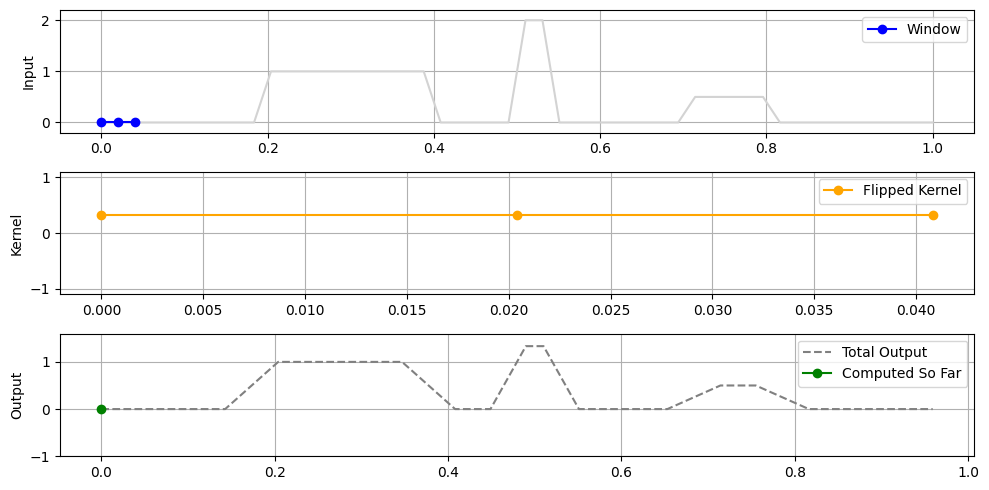

In [ ]:
show_convolution_visualizer(interactive=True)  # Set to True for sliders

## Finally convolutions on images

Convolution is an operation that “slides” a small kernel $K$ over an image $I$. At each location $(i,j)$, you take a weighted sum of the pixels under the kernel to produce the output pixel $O(i,j)$.

### Discrete Formula


$$
I \in \mathbb{R}^{H \times W}, 
\quad
K \in \mathbb{R}^{(2r+1) \times (2r+1)}, 
\quad
r = \frac{k-1}{2}.
$$  

The convolution $O = I * K$ is defined by  

$$
O(i,j)
=
\sum_{u=-r}^{r} \sum_{v=-r}^{r}
I\bigl(i+u,\,j+v\bigr)\;K\bigl(-u,\,-v\bigr),
$$

for $i = 0, \dots, H-1$ and $j = 0, \dots, W-1$.

> **Note:** The indices $(-u,-v)$ indicate that the kernel is flipped both horizontally and vertically.

```{admonition} Why Flip the Kernel?
:class: note, dropdown, closed

1. **Mathematical Consistency**  
   Flipping makes convolution commutative: 

   $$
   I * K = K * I,
   $$  

   which is important for many theoretical results (e.g., convolution theorems in Fourier analysis).

2. **System Response Interpretation**  
   In signal processing, convolution represents the response of a system with impulse response $K$. Flipping aligns the “past” and “future” contributions correctly.

3. **Distinction from Cross-Correlation**  
   If you omit the flip and write  

   $$
   \sum_{u=-r}^{r} \sum_{v=-r}^{r}
   I(i+u,\,j+v)\;K(u,v),
   $$  

   you get **cross-correlation** instead of convolution. Cross-correlation measures similarity, while convolution implements filtering.

Putting it all together, the flip ensures both the desired mathematical properties (commutativity, associativity) and the correct interpretation of the kernel as an impulse response.
```

```{admonition} Convolution with Stride and Padding
:class: tip, dropdown, closed 

- **Convolution with Stride and Padding**
  
$$
I \in \mathbb{R}^{H \times W}, \quad
K \in \mathbb{R}^{k \times k}, \quad
s \in \mathbb{N} \ (\text{stride}), \quad
p \in \mathbb{N} \ (\text{padding}).
$$

- **Padded Image**

We surround $I$ with a border of $p$ zeros on all sides to form  
$I_{\text{pad}} \in \mathbb{R}^{(H+2p) \times (W+2p)}$, defined by

$$
I_{\text{pad}}(x,y) =
\begin{cases}
I(x - p,\, y - p), & \text{if } 0 \leq x - p < H,\; 0 \leq y - p < W, \\
0, & \text{otherwise}.
\end{cases}
$$

- **Output Dimensions**

The output $O \in \mathbb{R}^{H_{\text{out}} \times W_{\text{out}}}$ has

$$
H_{\text{out}} = \left\lfloor \frac{H + 2p - k}{s} \right\rfloor + 1, \quad
W_{\text{out}} = \left\lfloor \frac{W + 2p - k}{s} \right\rfloor + 1.
$$

- **Convolution Operation**

Slide $K$ in steps of $s$ over $I_{\text{pad}}$:

$$
O(i,j) =
\sum_{u=0}^{k-1} \sum_{v=0}^{k-1}
I_{\text{pad}}(i \times s + u,\, j \times s + v) \times K(u,v),
$$

for $i = 0, \dots, H_{\text{out}}-1$ and $j = 0, \dots, W_{\text{out}}-1$.

---

- **Why These Matter**

- **Stride $s$:**  
  Controls how far the kernel jumps each time.  
  - $s=1$: full resolution  
  - $s>1$: downsampling (reduces output size and computation)

- **Padding $p$:**  
  Includes border pixels and controls output size.  
  - $p=0$: no padding (shrinks output)  
  - $p = \frac{k-1}{2}$ (for odd $k$): preserves input size (“same” convolution).
```  

```{figure} https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif
---
name: conv_demo
align: center
---
Convolution Example
```

### Convolution on 2D images Code

Test with different kernels to understand what features are extracted by convolution operations.

In [10]:
def pad_image(image, padding):
    """
    Zero-pad a 2D image.
    """
    return np.pad(image, pad_width=padding, mode='constant', constant_values=0)

def convolve2d(image, kernel, stride=1, padding=0):
    """
    Perform 2D convolution with optional stride and zero-padding.

    Args:
        image (np.ndarray): Grayscale image (H x W)
        kernel (np.ndarray): Convolution kernel (k x k)
        stride (int): Stride for sliding the kernel
        padding (int): Zero-padding size

    Returns:
        np.ndarray: Convolved output image
    """
    # Flip the kernel for convolution (not needed for cross-correlation)
    kernel = np.flipud(np.fliplr(kernel))

    # Pad the image
    if padding > 0:
        image = pad_image(image, padding)

    H, W = image.shape
    kH, kW = kernel.shape

    # Compute output dimensions
    out_H = (H - kH) // stride + 1
    out_W = (W - kW) // stride + 1

    # Initialize output
    output = np.zeros((out_H, out_W), dtype=np.float32)

    # Perform convolution
    for i in range(out_H):
        for j in range(out_W):
            region = image[i*stride:i*stride+kH, j*stride:j*stride+kW]
            output[i, j] = np.sum(region * kernel)

    # Normalize output to range [0, 255] for display
    output = np.clip(output, 0, 255)

    return output

def plot_images_grid(images, titles=None, images_per_row=2, figsize=(12, 6), cmap = None):
    num_images = len(images)
    num_rows = (num_images + images_per_row - 1) // images_per_row
 
    plt.figure(figsize=figsize)
    
    for idx, img in enumerate(images):
        plt.subplot(num_rows, images_per_row, idx + 1)
        plt.imshow(img, cmap=cmap)
        if titles and idx < len(titles):
            plt.title(titles[idx])
        img_shape = f"{img.shape[0]}x{img.shape[1]}"
        plt.xlabel(f"Shape: {img_shape}", fontsize=9)
        plt.axis('off')
 
    plt.tight_layout()
    plt.show()
    
from skimage.data import camera
import numpy as np

# 1. Identity (no change)
identity_kernel = np.array([
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
], dtype=np.float32)

# 2. Simple blur (average)
blur_kernel = np.ones((3, 3), dtype=np.float32) / 9.0

# 3. Gaussian blur
gaussian_blur_kernel = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]
], dtype=np.float32) / 16.0

# 4. Sharpen
sharpen_kernel = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
], dtype=np.float32)

# 5. Edge detection (Sobel X)
sobel_x_kernel = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
], dtype=np.float32)

# 6. Edge detection (Sobel Y)
sobel_y_kernel = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
], dtype=np.float32)

# 7. Laplacian (strong edge detection)
laplacian_kernel = np.array([
    [0, -1, 0],
    [-1, 4, -1],
    [0, -1, 0]
], dtype=np.float32)

# 8. Emboss
emboss_kernel = np.array([
    [-2, -1, 0],
    [-1, 1, 1],
    [0, 1, 2]
], dtype=np.float32)

# 9. Outline
outline_kernel = np.array([
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1]
], dtype=np.float32)

# 10. Box edge (another edge detector)
box_edge_kernel = np.array([
    [1, 1, 1],
    [1, -8, 1],
    [1, 1, 1]
], dtype=np.float32)

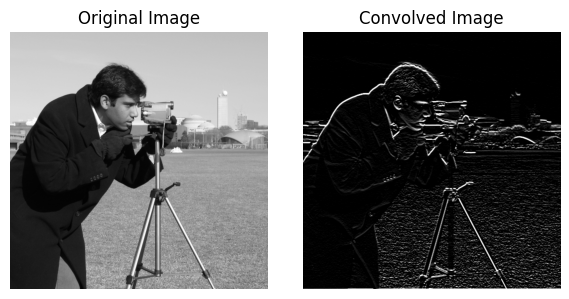

In [ ]:
image = camera().astype(np.float32) # example image

kernel = sobel_y_kernel

# Apply convolution
convolved_img = convolve2d(image, kernel, stride=1, padding=1)  # padding=1 to preserve size

plot_images_grid([image, convolved_img], titles=["Original Image", "Convolved Image"], images_per_row=2, figsize=(6, 3), cmap = "gray")

In the next lecture, we will discuss Image Processing in the Fourier Space.